In [9]:
"trivy-results-15.json", "Trivy.txt", "ONOS"

('trivy-results-15.json', 'Trivy.txt', 'ONOS')

Trivy: Skipping:onos-a1t/test/utils/xapp/go.mod
Trivy: Skipping:onos-config/benchmark/go.mod
Trivy: Skipping:onos-config/test/go.mod
Trivy: Skipping:onos-e2t/test/go.mod
Trivy: Skipping:onos-topo/test/go.mod
Finished writing: sca_results.json
Finished reading the SCA results data.
onos-a1t
Vulnerability without CVSS: GHSA-7ww5-4wqc-m92c
Vulnerability without CVSS: GHSA-c9cp-9c75-9v8c
Vulnerability without CVSS: GHSA-6xv5-86q9-7xr8
Vulnerability without CVSS: GHSA-xmmx-7jpf-fx42
Vulnerability without CVSS: GHSA-jq35-85cj-fj4p
Vulnerability without CVSS: GHSA-8r3f-844c-mc37
Vulnerability without CVSS: GHSA-jw44-4f3j-q396
Vulnerability without CVSS: GHSA-7ww5-4wqc-m92c
Vulnerability without CVSS: GHSA-c9cp-9c75-9v8c
Vulnerability without CVSS: GHSA-6xv5-86q9-7xr8
Vulnerability without CVSS: GHSA-jq35-85cj-fj4p
Vulnerability without CVSS: GHSA-xmmx-7jpf-fx42
Vulnerability without CVSS: GHSA-vp35-85q5-9f25
More CVSS than CVE
onos-cli
Vulnerability without CVSS: GHSA-8r3f-844c-mc37
More CVSS

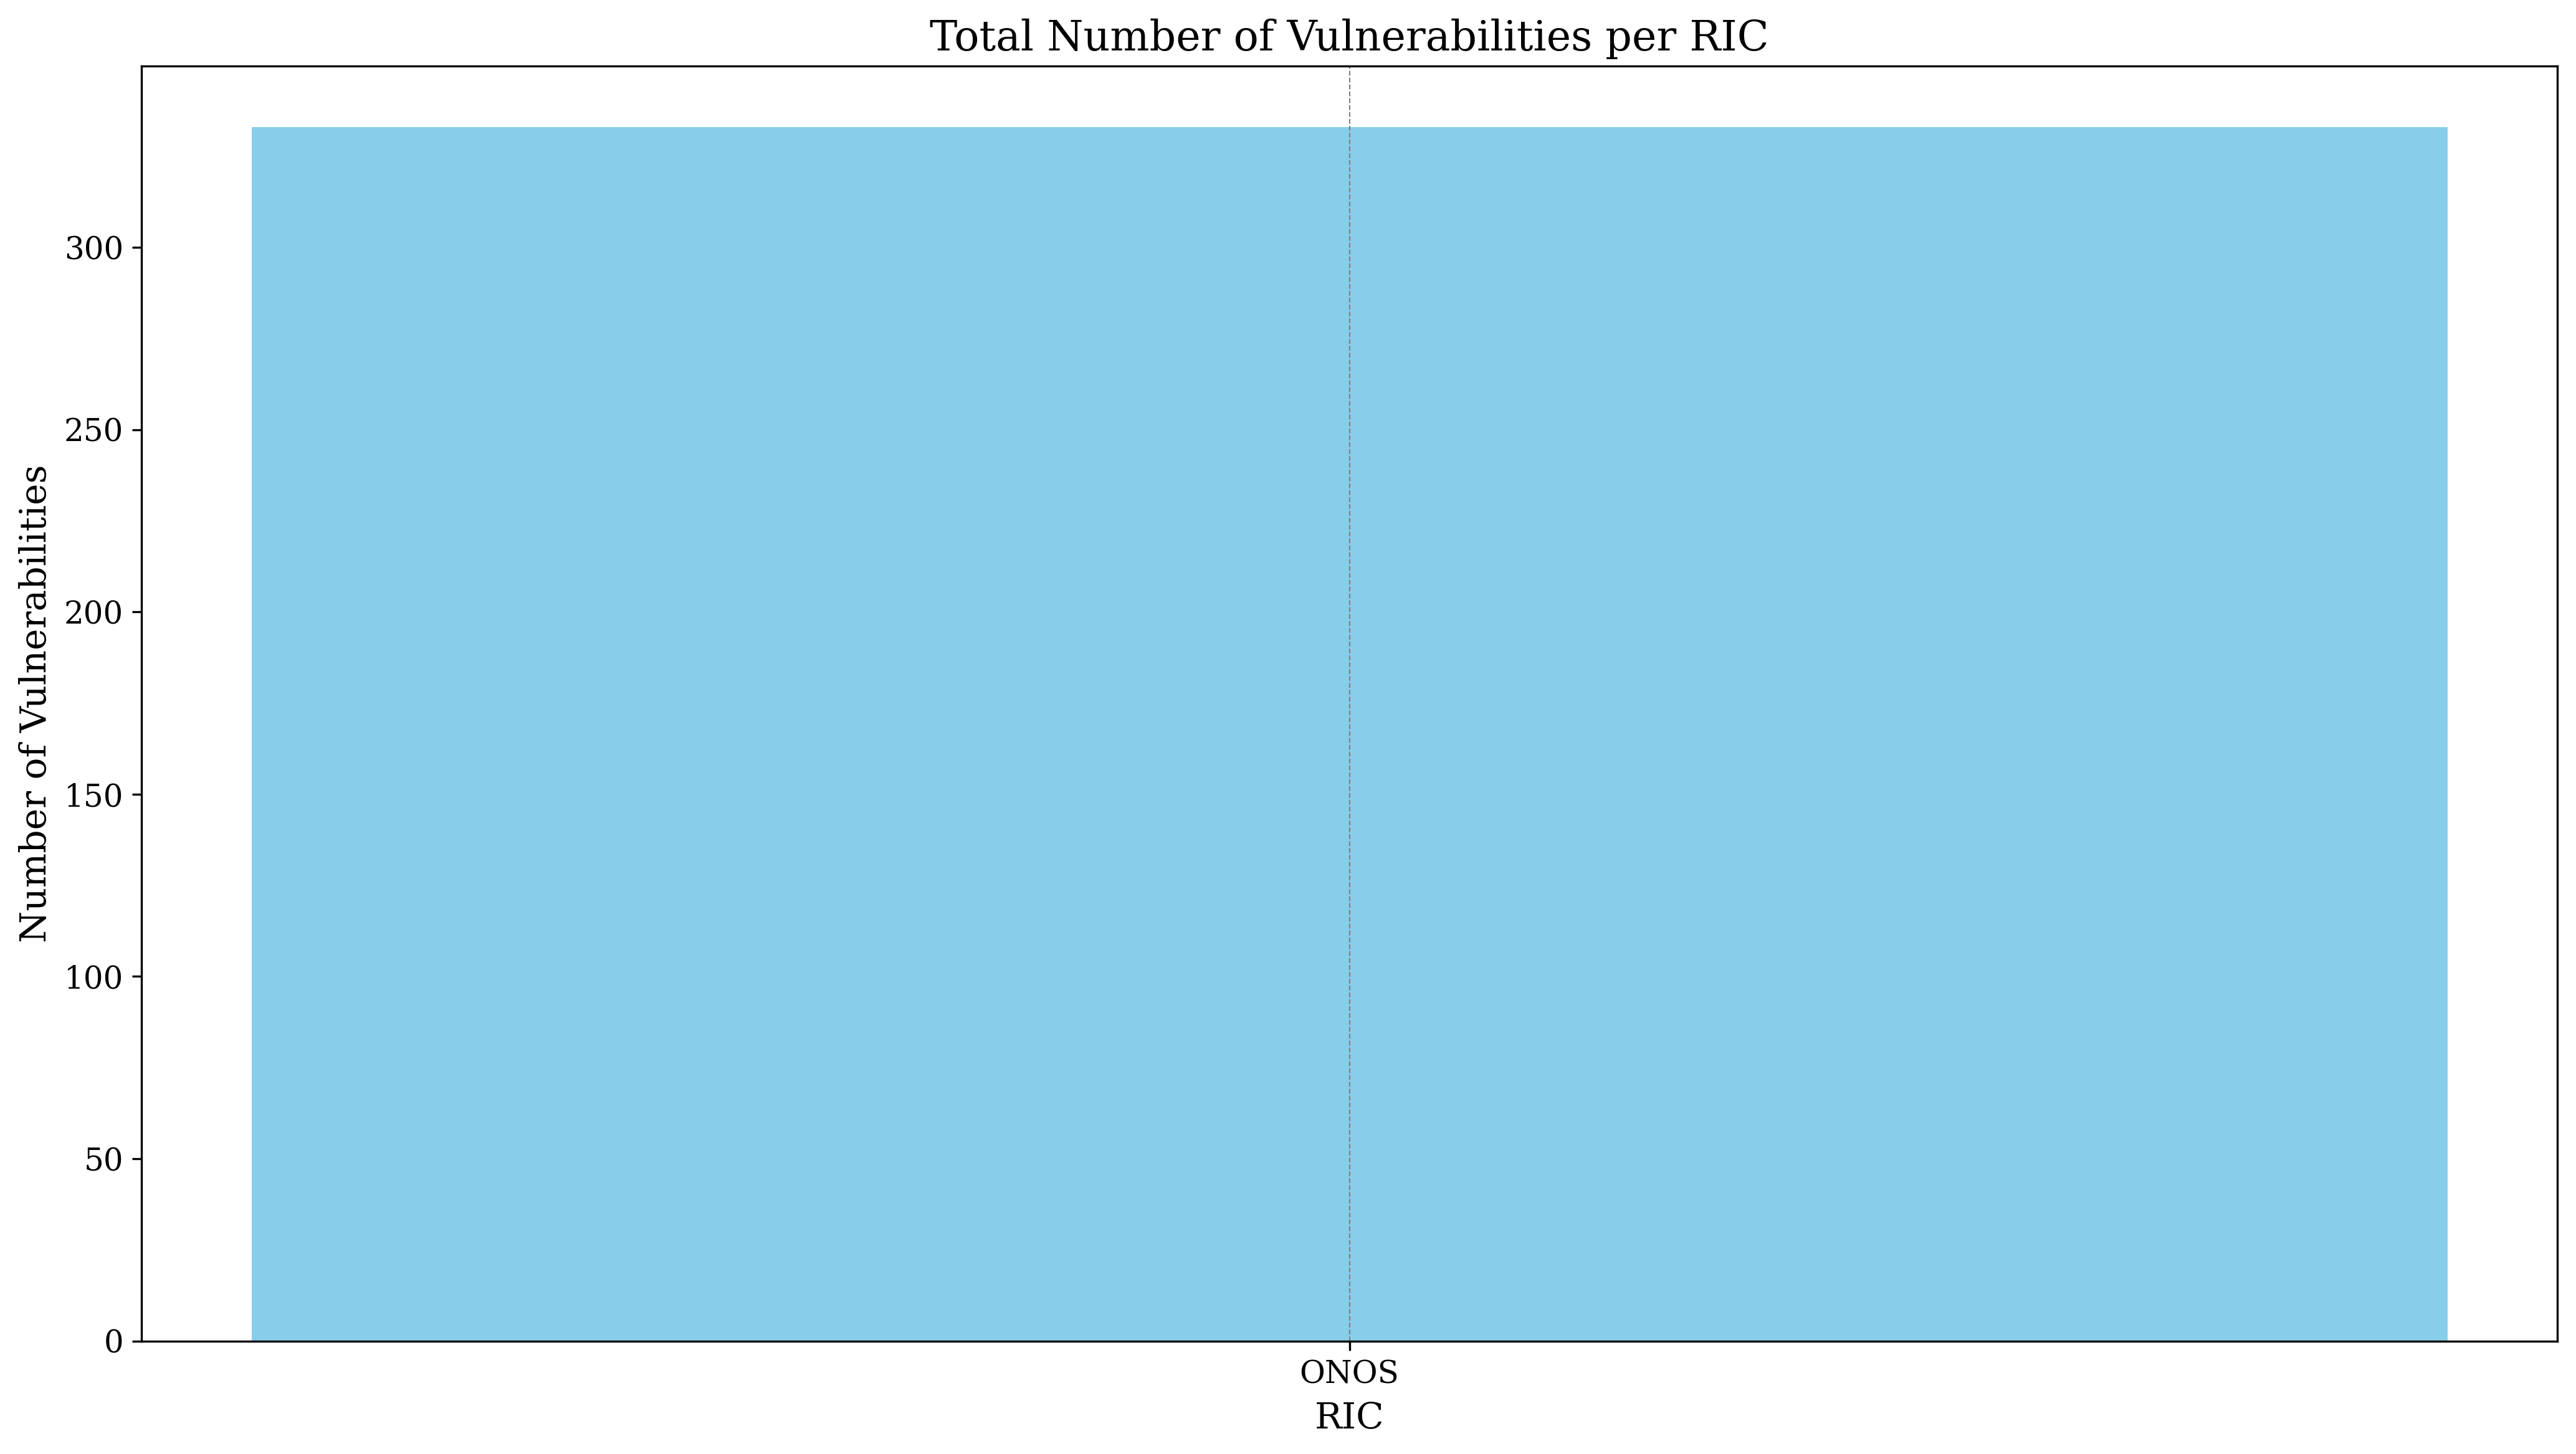

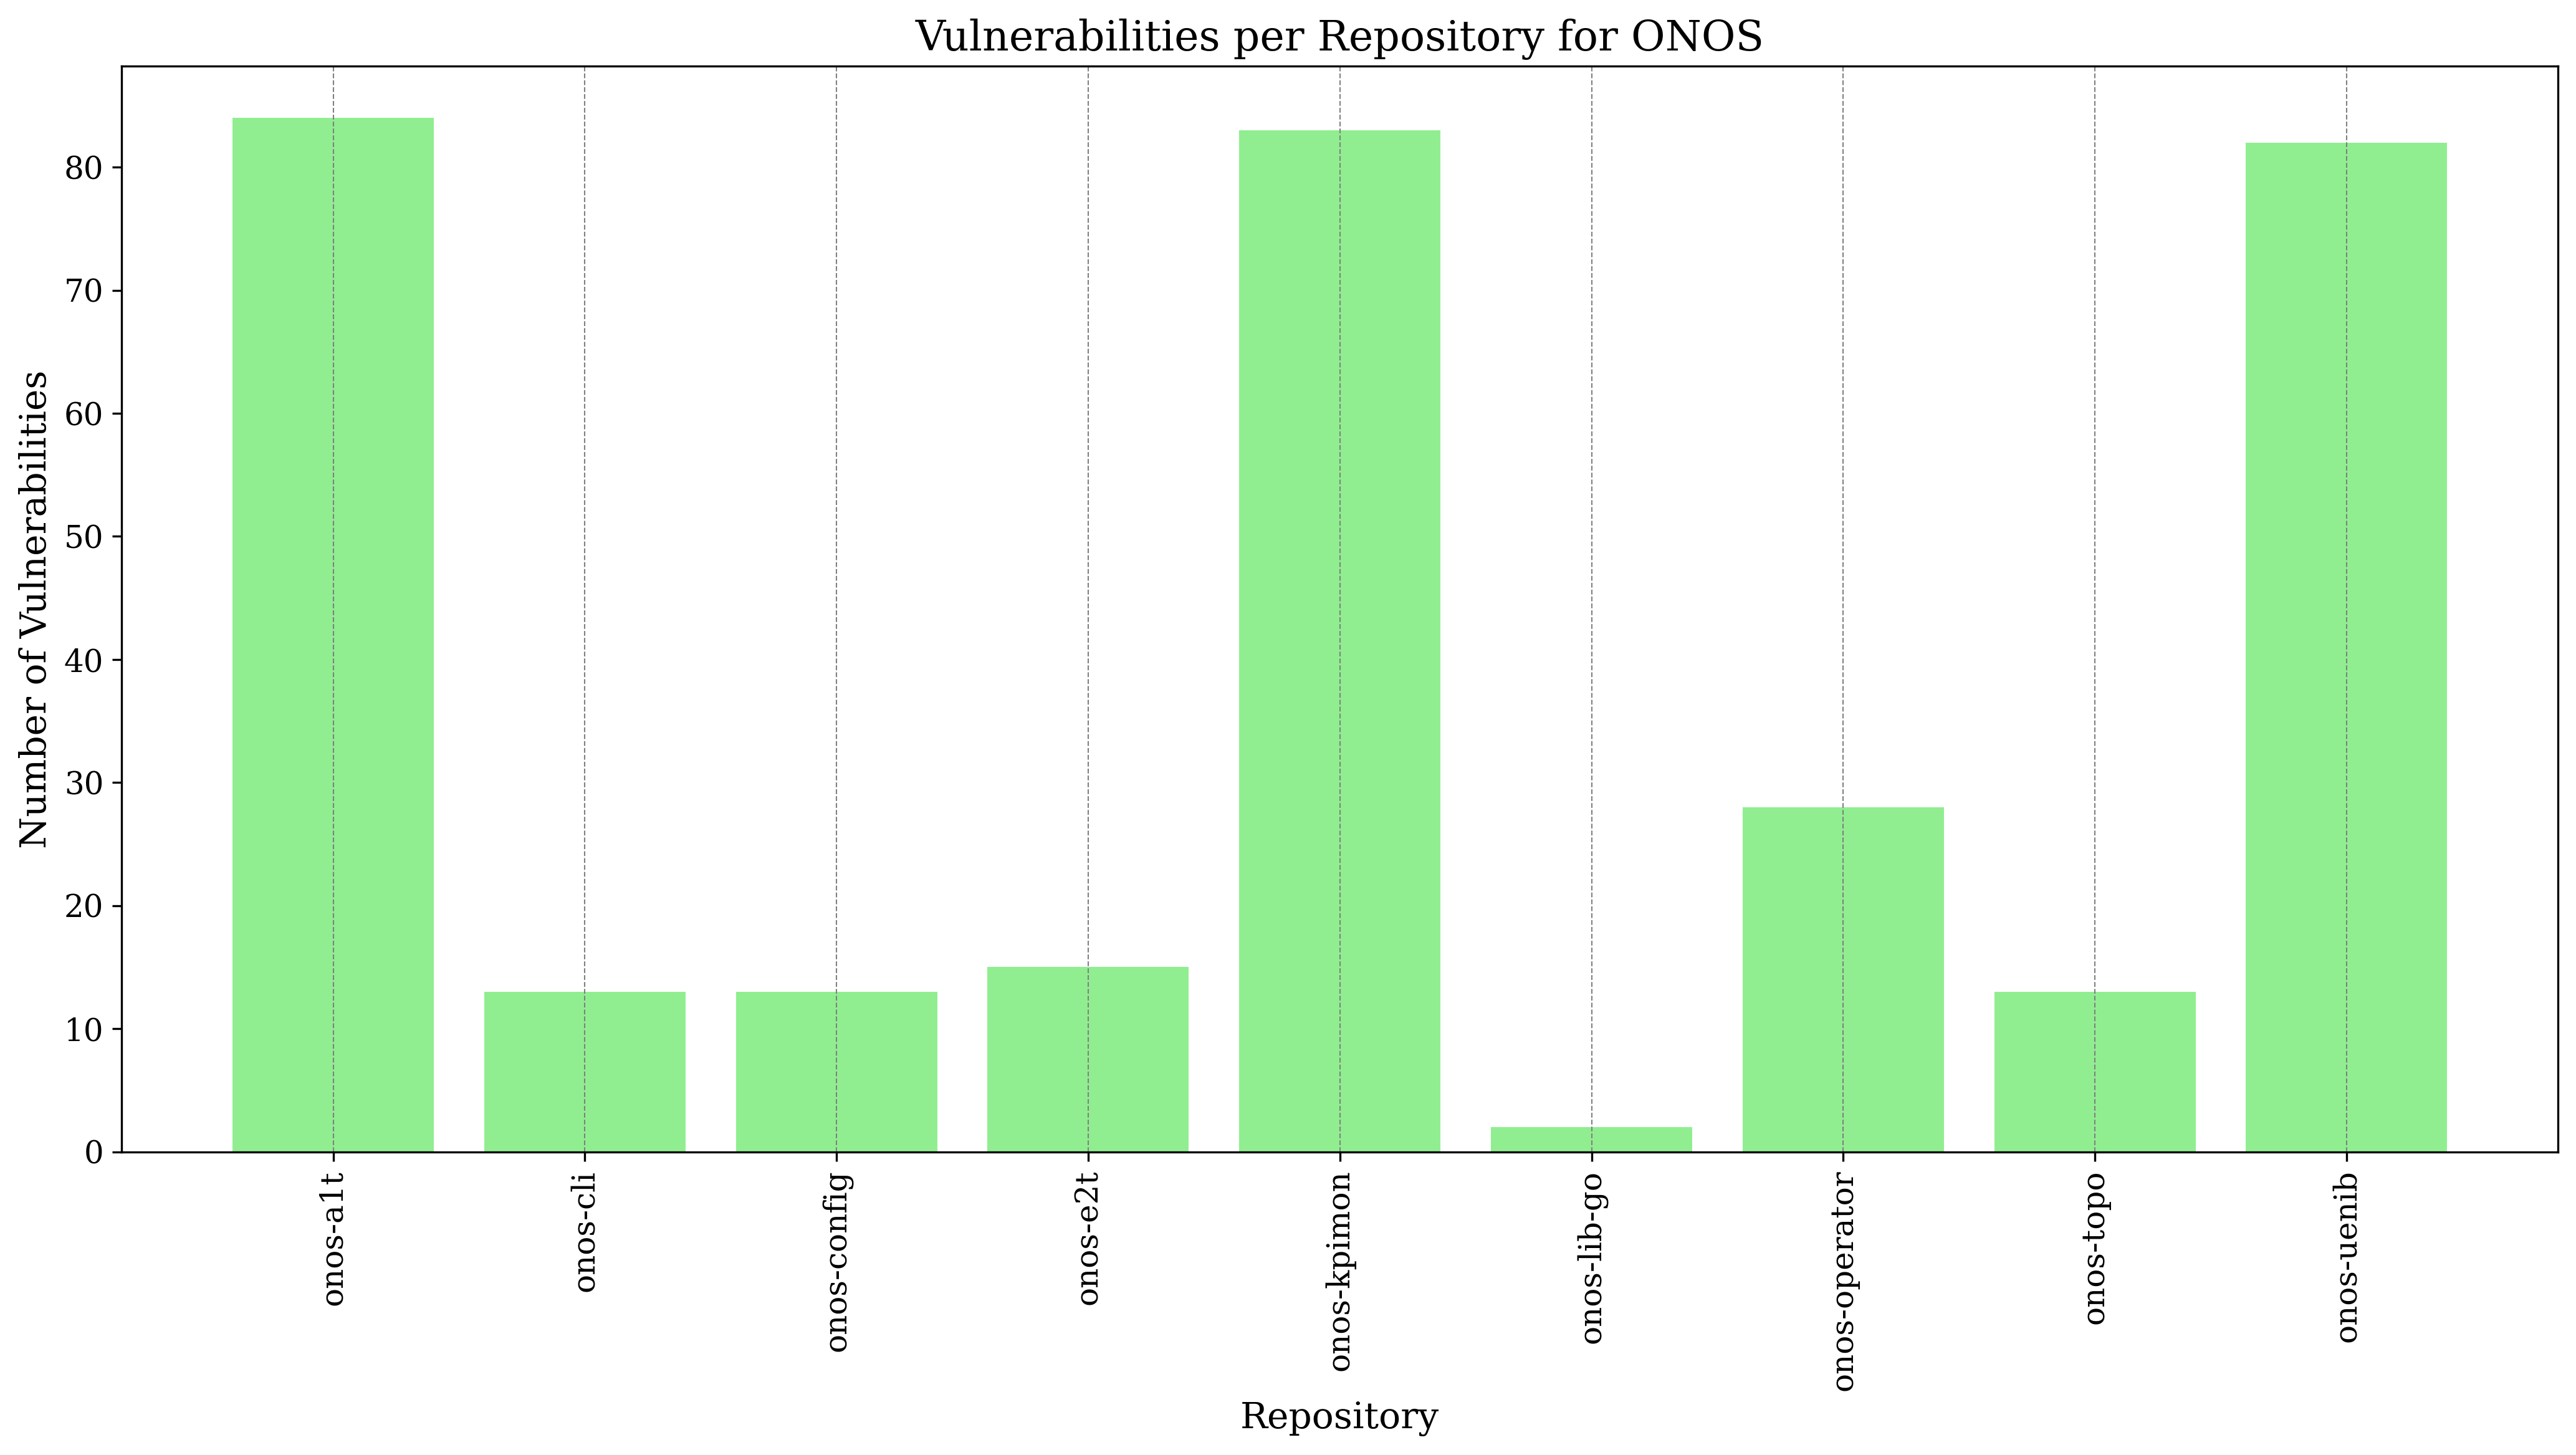

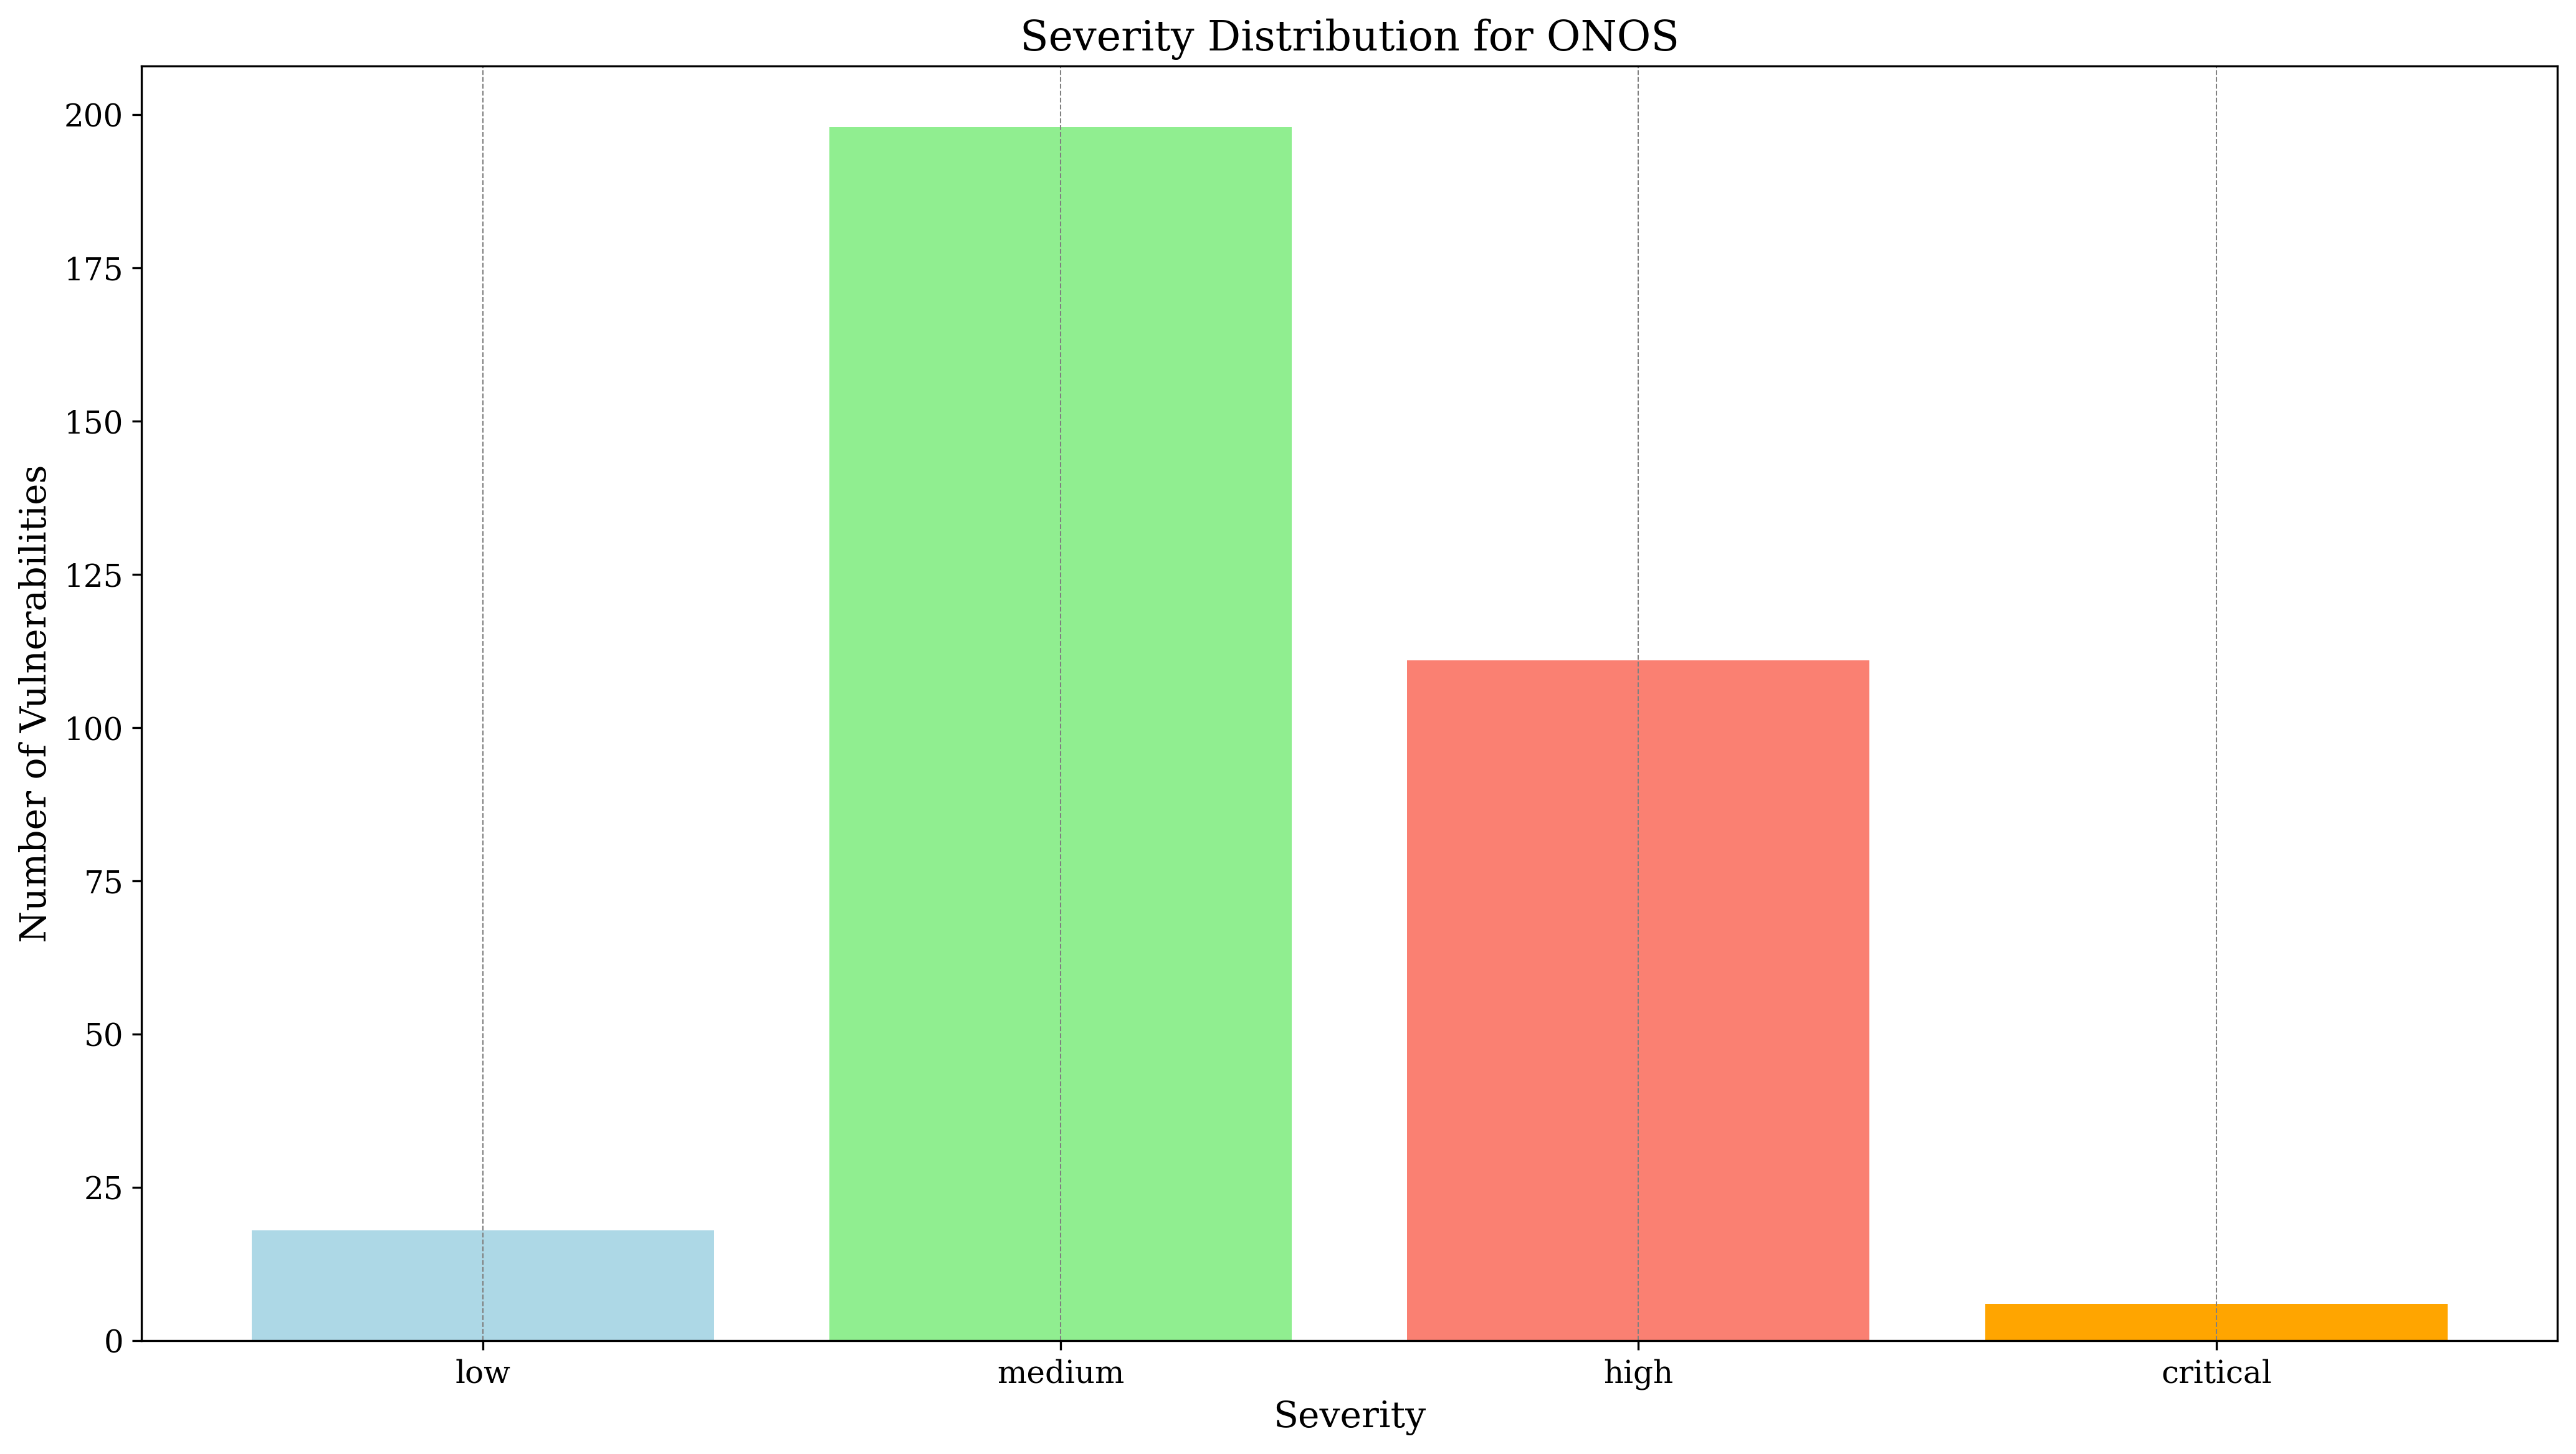

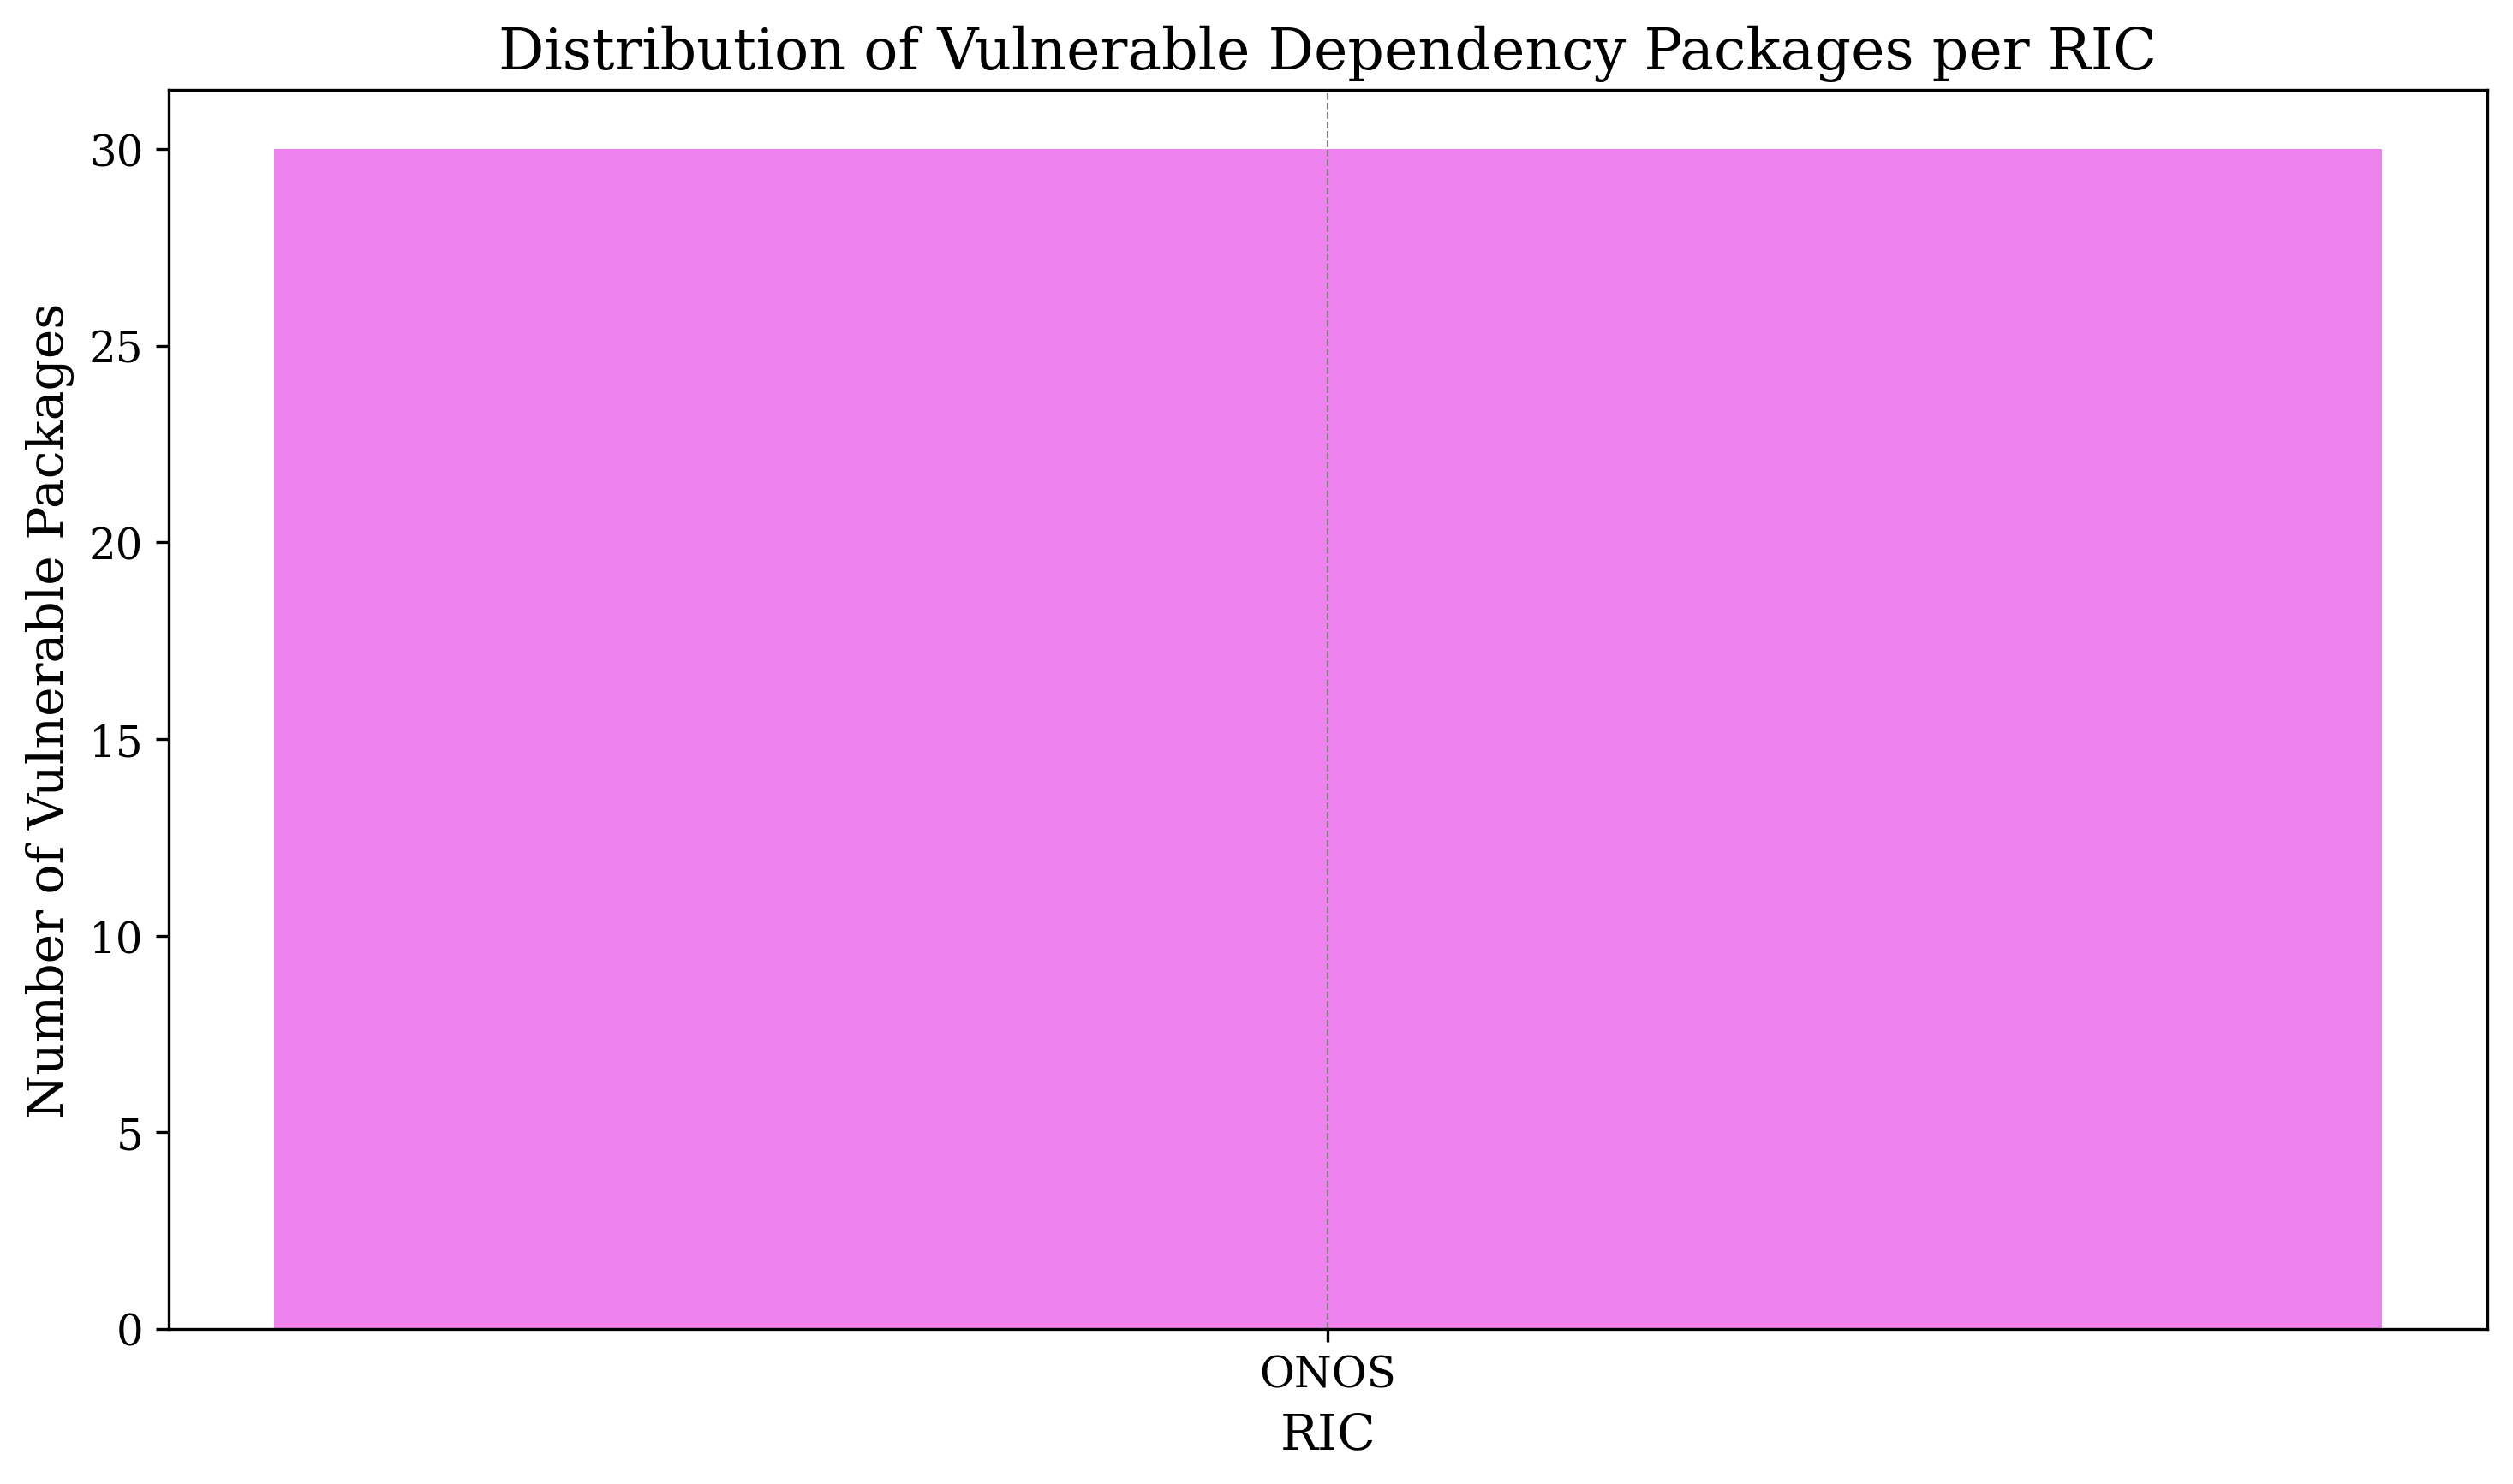

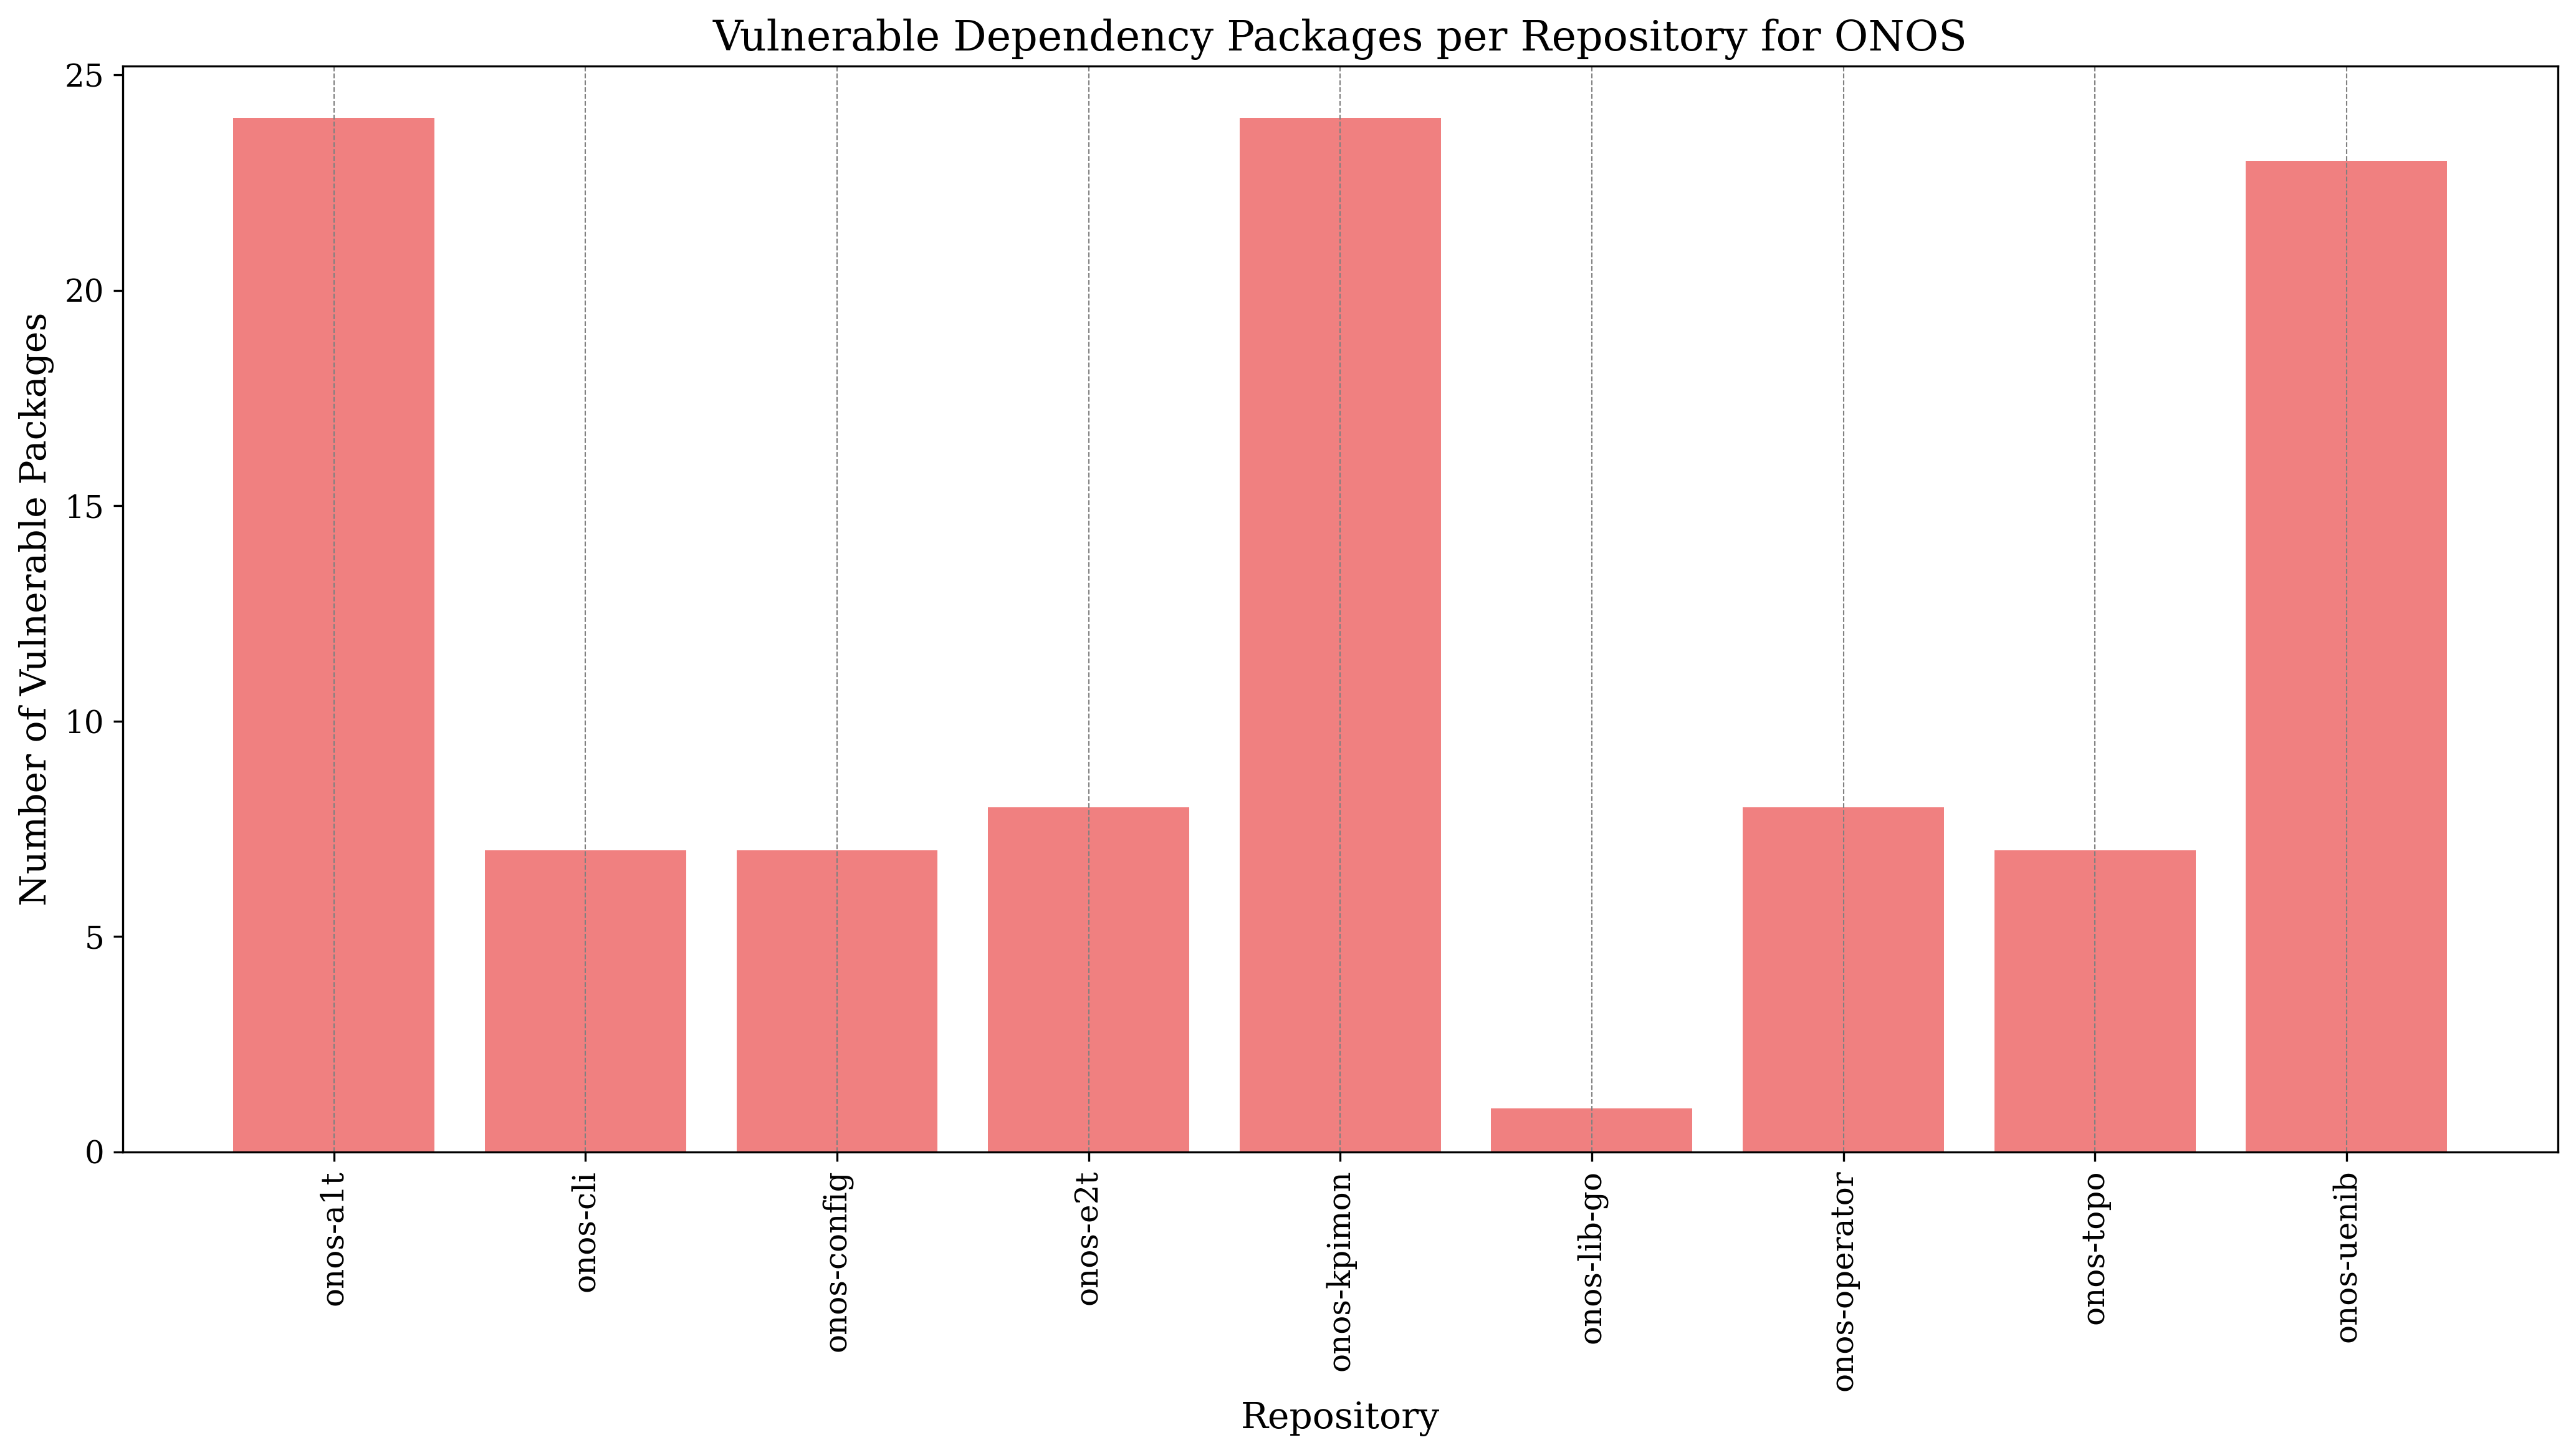

In [19]:
import os
import json
import pprint
import re
import argparse
from statistics import mean
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt


# Tools used for SCA
sca_tools = ['Grype.txt', 'Snyk.txt', 'Trivy.txt']

# RICs (Radio Interface Controllers) to analyze
rics = ['ONOS', 'OSC']

# List to store repositories with errors
repoWithError = []

# Regular expressions to exclude certain packages in the RIC repositories
test_package = re.compile(r'test/')
benchmark_package = re.compile(r'benchmark')
examples_package = re.compile(r'examples/')
testapplication_package = re.compile(r'testapplication/')
cert_package = re.compile(r'certs/')

# Normalize the results from each tool
def format_sca_tool_data(repository, tool):
    if tool == "Grype.txt":
        return formatGrype(repository)
    elif tool == "Snyk.txt":
        return formatSnyk(repository)
    elif tool == "Trivy.txt":
        return formatTrivy(repository)

# Format the results from Grype tool
def formatGrype(repository):
    GrypeRepo = json.loads(repository)
    vulnArray = []
    for vuln in GrypeRepo["matches"]:
        path = vuln.get("artifact").get("locations")[0].get("path")
        if test_package.search(path) is not None:
            continue
        elif benchmark_package.search(path) is not None:
            continue
        elif examples_package.search(path) is not None:
            continue
        elif testapplication_package.search(path) is not None:
            continue
        else:
            vulnArray.append(vuln)
    return vulnArray

# Format the results from Snyk tool
def formatSnyk(repository):
    content = json.loads(repository)
    vulnArray = []
    if "error" not in content:
        for target in content:
            if not isinstance(target, str):
                vulnList = target.get('vulnerabilities')
                path = target.get('displayTargetFile')
                if test_package.search(path) is not None:
                    print("Snyk: Skipping:" + path)
                    continue
                elif benchmark_package.search(path) is not None:
                    print("Snyk: Skipping:" + path)
                    continue
                elif examples_package.search(path) is not None:
                    print("Snyk: Skipping:" + path)
                    continue
                elif testapplication_package.search(path) is not None:
                    print("Snyk: Skipping:" + path)
                    continue
                else:
                    for vuln in vulnList:
                        vuln.pop('semver')
                        vulnArray.append(vuln)
            else:
                if target == 'vulnerabilities':
                    vulnList = content.get('vulnerabilities')
                    path = content.get('displayTargetFile')
                    print("Snyk path: {}".format(path))
                    if test_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif benchmark_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif examples_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif testapplication_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    else:
                        for vuln in vulnList:
                            vuln.pop('semver')
                            vulnArray.append(vuln)
                            print("1")
    else:
        global repoWithError
        repoWithError.append(os.path.basename(content['path']))
    return vulnArray

# Format the results from Trivy tool
def formatTrivy(repository):
    index = repository.find("{")
    repo = repository[index:]
    TrivyRepo = json.loads(repo)
    results = TrivyRepo.get("Results")
    vulnArray = []
    if results is not None:
        for target in results:
            path = target.get("Target")
            if test_package.search(path) is not None:
                print("Trivy: Skipping:" + path)
                continue
            elif benchmark_package.search(path) is not None:
                print("Trivy: Skipping:" + path)
                continue
            elif examples_package.search(path) is not None:
                print("Trivy: Skipping:" + path)
                continue
            else:
                vulnTarget = target.get("Vulnerabilities", [])
                if not vulnTarget:
                    continue
                for vuln in vulnTarget:
                    vuln["Path"] = path
                vulnArray.extend(vulnTarget)
    return vulnArray

# Get vulnerabilities categorized by directories
def get_vulnerabilities_by_directory(data, tool):
    # For Grype we can work with the formatted data directly
    if tool == "Grype.txt":
        formatted_data = format_sca_tool_data(data, "Grype.txt")
    
    # For Trivy we need to load the data into a JSON object first
    elif tool == "Trivy.txt":
        repo = json.loads(data)
        results = repo.get("Results")

    # For Snyk we load the data as JSON
    elif tool == "Snyk.txt":
        content = json.loads(data)

    vulnerabilities_by_directory = defaultdict(list)
    
    if tool == "Grype.txt":
        for vuln in formatted_data:
            path = vuln.get("artifact").get("locations")[0].get("path")
            directory = os.path.dirname(path)
            vulnerabilities_by_directory[directory].append(vuln)
        return vulnerabilities_by_directory
    
    elif tool == "Trivy.txt":
        for vuln in results:
            path = vuln.get("Target")
            if test_package.search(path) is not None:
                continue
            elif benchmark_package.search(path) is not None:
                continue
            elif examples_package.search(path) is not None:
                continue
            elif cert_package.search(path) is not None:
                continue
            else:
                vulnTarget = vuln.get("Vulnerabilities", [])
                if not vulnTarget:
                    continue
                for vuln in vulnTarget:
                    vuln["Path"] = path
                    directory = os.path.dirname(path)
                    vulnerabilities_by_directory[directory].append(vuln)
        return vulnerabilities_by_directory
    
    elif tool == "Snyk.txt":
        if "error" not in content:
            for target in content:
                if not isinstance(target, str):
                    vulnList = target.get('vulnerabilities')
                    path = target.get('displayTargetFile')
                    if test_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif benchmark_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif examples_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    elif testapplication_package.search(path) is not None:
                        print("Snyk: Skipping:" + path)
                        continue
                    else:
                        for vuln in vulnList:
                            directory = os.path.dirname(path)
                            vulnerabilities_by_directory[directory].append(vuln)
                else:
                    if target == 'vulnerabilities':
                        vulnList = content.get('vulnerabilities')
                        path = content.get('displayTargetFile')
                        print("Snyk path: {}".format(path))
                        if test_package.search(path) is not None:
                            print("Snyk: Skipping:" + path)
                            continue
                        elif benchmark_package.search(path) is not None:
                            print("Snyk: Skipping:" + path)
                            continue
                        elif examples_package.search(path) is not None:
                            print("Snyk: Skipping:" + path)
                            continue
                        elif testapplication_package.search(path) is not None:
                            print("Snyk: Skipping:" + path)
                            continue
                        else:
                            for vuln in vulnList:
                                directory = os.path.dirname(path)
                                vulnerabilities_by_directory[directory].append(vuln)
    return vulnerabilities_by_directory

# Save vulnerabilities by directory
def save_vulnerabilities_by_directory(vulnerabilities_by_directory, tool, base_dir):
    for directory, vulnerabilities in vulnerabilities_by_directory.items():
        clean_directory = re.sub(r'[^a-zA-Z0-9_\-]', '', directory)
        dir_path = os.path.join(base_dir, clean_directory)
        os.makedirs(dir_path, exist_ok=True)
        filename = f"{tool}"
        filepath = os.path.join(dir_path, filename)
        with open(filepath, 'w') as json_file:
            json.dump(vulnerabilities, json_file, separators=(',', ':'))

# Dump scan results into a JSON file
def dump_scan_results(rics, sca_tools):
    scan_results = dict.fromkeys(rics)
    onos_repos = []
    osc_repos = []
    for ric in rics:
        ric_dir = "./" + ric
        if not os.path.exists(ric_dir):
            os.makedirs(ric_dir)
        for repository in sorted(os.listdir(ric_dir)):
            if ric == "ONOS":
                onos_repos.append(repository)
            elif ric == "OSC":
                osc_repos.append(repository)
    for ric in rics:
        if ric == "ONOS":
            scan_results[ric] = dict.fromkeys(onos_repos)
        elif ric == "OSC":
            scan_results[ric] = dict.fromkeys(osc_repos)
        for repository in sorted(os.listdir("./" + ric)):
            scan_results[ric][repository] = dict.fromkeys(sca_tools)
            path_to_repository = os.path.join("./" + ric, repository)
            for sca_tool_file in sorted(os.listdir(path_to_repository)):
                sca_tool_file_path = os.path.join(path_to_repository, sca_tool_file)
                with open(sca_tool_file_path) as file:
                    vuln = file.read()
                scan_results[ric][repository][sca_tool_file] = vuln
    with open('sca_results.json', 'w') as file:
        json.dump(scan_results, file)
    print("Finished writing: " + 'sca_results.json')
    return scan_results

# Extract CVEs and CVSS dependencies from the scan results
def get_cves_cvss_dependencies(sca_tool, sca_tool_data):
    cves_cvss_dependencies = []
    cves = []
    cvss = []
    packages = []
    if sca_tool == "Grype.txt":
        for vulnerability in sca_tool_data:
            if vulnerability.get("vulnerability").get("id") not in cves:
                cves.append(vulnerability.get("vulnerability").get("id"))
                cvss_info = vulnerability.get("vulnerability").get("cvss")
                if cvss_info and len(cvss_info) > 0:
                    cvss.append(cvss_info[0].get("metrics").get("baseScore"))
                else:
                    cvss.append(None)
                    print(f"Vulnerability without CVSS: {vulnerability.get('vulnerability').get('id')}")
                vulnerability_match_details = vulnerability.get("matchDetails")
                for match_detail in vulnerability_match_details:
                    if "package" in match_detail["searchedBy"].keys():
                        packages.append(match_detail["searchedBy"]["package"]["name"])
                    elif "Package" in match_detail["searchedBy"].keys():
                        packages.append(match_detail["searchedBy"]["Package"]["name"])
            else:
                continue
        cves_cvss_dependencies = [cves, cvss, packages]
        return cves_cvss_dependencies
    elif sca_tool == "Snyk.txt":
        for vulnerability in sca_tool_data:
            if len(vulnerability.get("identifiers").get("CVE")) == 0:
                continue
            else:
                if vulnerability.get("identifiers").get("CVE")[0] not in cves:
                    cves.append(vulnerability.get("identifiers").get("CVE")[0])
                    cvss.append(vulnerability.get("cvssScore"))
                    packages.append(vulnerability.get("moduleName"))
        cves_cvss_dependencies = [cves, cvss, packages]
        return cves_cvss_dependencies
    elif sca_tool == "Trivy.txt":
        for vulnerability in sca_tool_data:
            if vulnerability.get("VulnerabilityID") not in cves:
                if vulnerability.get("CVSS") is not None:
                    cves.append(vulnerability.get("VulnerabilityID"))
                    packages.append(vulnerability.get("PkgName"))
                    nvd = vulnerability.get("CVSS").get("nvd")
                    ghsa = vulnerability.get("CVSS").get("ghsa")
                    if nvd is not None:
                        cvss.append(nvd.get("V3Score"))
                        continue
                    elif ghsa is not None:
                        cvss.append(ghsa.get("V3Score"))
                        continue
                else:
                    print(f"Vulnerability without CVSS: {vulnerability.get('VulnerabilityID')}")
                    continue
        cves_cvss_dependencies = [cves, cvss, packages]
        return cves_cvss_dependencies
    else:
        print("Unknown tool")
    return cves_cvss_dependencies

# Extract CVEs from the scan results
def extract_cves(sca_results):
    # Initialize the dictionary to store CVE and CVSS dependencies
    sca_cvecvss_dependencies = dict.fromkeys(sca_results.keys())
    
    print("Finished reading the SCA results data.")
    
    for ric in sca_results.keys():
        # Create repos as keys
        sca_cvecvss_dependencies[ric] = dict.fromkeys(sca_results[ric].keys())
        for repository in sca_results[ric].keys():
            sca_cvecvss_dependencies[ric][repository] = dict.fromkeys(sca_results[ric][repository].keys())
            print(repository)
            for sca_tool in sca_results[ric][repository].keys():
                sca_tool_data_str = sca_results[ric][repository][sca_tool]
                if sca_tool_data_str is not None:  # Check if the data is not None
                    try:
                        sca_tool_data = json.loads(sca_tool_data_str)
                        sca_cvecvss_dependencies[ric][repository][sca_tool] = get_cves_cvss_dependencies(sca_tool, sca_tool_data)
                        if len(sca_cvecvss_dependencies[ric][repository][sca_tool][0]) != len(sca_cvecvss_dependencies[ric][repository][sca_tool][1]):
                            print("More CVSS than CVE")
                    except json.JSONDecodeError:
                        print(f"Error decoding JSON for RIC: {ric}, Repository: {repository}, SCA_Tool: {sca_tool}")
                else:
                    print(f"NoneType found for RIC: {ric}, Repository: {repository}, SCA_Tool: {sca_tool}")
                    print(f"sca_tool_data_str: {sca_tool_data_str}")
    return sca_cvecvss_dependencies

# Count CVEs per repository and RIC
def count_cves(cve_data):
    print("Going to count CVEs per repo and per RIC")

    # Initialize the dictionary to store CVE counts per RIC
    ric_cves = dict.fromkeys(cve_data.keys())

    for ric in cve_data.keys():
        total_ric_cves = []
        for repository in cve_data[ric].keys():
            total_repo_cves = []
            for sca_tool in cve_data[ric][repository].keys():
                if cve_data[ric][repository][sca_tool] is None or cve_data[ric][repository][sca_tool][0] is None:
                    print(f"NoneType found for RIC: {ric}, Repository: {repository}, SCA_Tool: {sca_tool}")
                    total_cve_count = 0
                else:
                    try:
                        total_cve_count = len(cve_data[ric][repository][sca_tool][0])
                    except TypeError as e:
                        print(f"NoneType found for RIC: {ric}, Repository: {repository}, SCA_Tool: {sca_tool}")
                        print(f"Exception: {e}")
                        total_cve_count = 0
                
                if cve_data[ric][repository][sca_tool] is not None and cve_data[ric][repository][sca_tool][0] is not None:
                    for cve in cve_data[ric][repository][sca_tool][0]:
                        if cve not in total_repo_cves:
                            total_repo_cves.append(cve)
            
            print("RIC: {}, Repository: {}, Total Repo CVEs: {}".format(ric, repository, len(total_repo_cves)))
            total_ric_cves.extend(total_repo_cves)
        
        ric_cves[ric] = total_ric_cves
    
    pprint.pprint(ric_cves)
    for ric in ric_cves.keys():
        print("RIC: {}, Total unique CVEs: {}".format(ric, len(ric_cves[ric])))

# Count CVEs per repository and tool
def per_repo_cve_count(cve_data):
    print("1. CVEs per RIC/repo/tool\n"
          "2. Total CVEs per RIC/repo with duplicates\n"
          "3. Total CVEs per RIC/repo without duplicates")
    
    # First CVEs per RIC/repo/tool
    cve_per_ric_repo_tool = dict.fromkeys(rics)
    for ric in cve_data.keys():
        cve_per_ric_repo_tool[ric] = dict.fromkeys(cve_data[ric].keys())
        for repository in cve_data[ric].keys():
            cve_per_ric_repo_tool[ric][repository] = dict.fromkeys(cve_data[ric][repository].keys())
            for sca_tool in cve_data[ric][repository].keys():
                if cve_data[ric][repository][sca_tool] is None:
                        cve_per_ric_repo_tool[ric][repository][sca_tool] = 0
                else:
                        try:
                            cve_per_ric_repo_tool[ric][repository][sca_tool] = len(cve_data[ric][repository][sca_tool][0])
                        except TypeError as e:
                            print(f"NoneType found for RIC: {ric}, Repository: {repository}, SCA_Tool: {sca_tool}")
                            print(f"Exception: {e}")
                            cve_per_ric_repo_tool[ric][repository][sca_tool] = 0

    # Combine the CVEs from all the tools and save two lists with duplicates and without duplicates
    cve_per_ric_repo = dict.fromkeys(rics)
    for ric in cve_data.keys():
        cve_per_ric_repo[ric] = dict.fromkeys(cve_data[ric].keys())
        for repository in cve_data[ric].keys():
            cve_list_with_dups = []
            cve_list_without_dups = []
            for sca_tool in cve_data[ric][repository].keys():  
                try:
                    for cve in cve_data[ric][repository][sca_tool][0]:
                        cve_list_with_dups.append(cve)
                        if cve not in cve_list_without_dups:
                            cve_list_without_dups.append(cve)
                except TypeError as e:
                    print(f"NoneType found for RIC: {ric}, Repository: {repository}, SCA_Tool: {sca_tool}")
                    print(f"Exception: {e}")
            cve_per_ric_repo[ric][repository] = [cve_list_with_dups, cve_list_without_dups]
    return cve_per_ric_repo_tool, cve_per_ric_repo

# Analyze the distribution of CVSS scores
def cvss_distribution(cvss_data):
    for ric in cvss_data.keys():
        total_cve_count = 0
        total_cvss_count = 0
        for repository in cvss_data[ric].keys():
            for sca_tool in cvss_data[ric][repository].keys():
                if cvss_data[ric][repository][sca_tool] is not None:
                    total_cve_count += len(cvss_data[ric][repository][sca_tool][0])
                    total_cvss_count += len(cvss_data[ric][repository][sca_tool][1])

    # Initialize dictionaries for CVSS distribution
    low_cvss_per_ric_repo = dict.fromkeys(cvss_data.keys())
    medium_cvss_per_ric_repo = dict.fromkeys(cvss_data.keys())
    high_cvss_per_ric_repo = dict.fromkeys(cvss_data.keys())
    critical_cvss_per_ric_repo = dict.fromkeys(cvss_data.keys())
    cve_per_ric_repo = dict.fromkeys(cvss_data.keys())
    none_counter = 0
    
    for ric in cvss_data.keys():
        low_cvss_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        medium_cvss_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        high_cvss_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        critical_cvss_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        cve_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        
        for repository in cvss_data[ric].keys():
            low_cvss_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            medium_cvss_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            high_cvss_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            critical_cvss_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            cve_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            
            low_cves = []
            medium_cves = []
            high_cves = []
            critical_cves = []
            cves = []
            
            for sca_tool in cvss_data[ric][repository].keys():
                if cvss_data[ric][repository][sca_tool] is not None and sca_tool != "Scantist.json":
                    for index, cvss in enumerate(cvss_data[ric][repository][sca_tool][1]):
                        cve = cvss_data[ric][repository][sca_tool][0][index]
                        if cvss is None:
                            none_counter += 1
                        elif 0.1 <= cvss <= 3.9:
                            if cve not in low_cves and cve not in medium_cves and cve not in high_cves and cve not in critical_cves:
                                low_cves.append(cve)
                            if cve not in cves:
                                cves.append(cve)
                        elif 4.0 <= cvss <= 6.9:
                            if cve not in low_cves and cve not in medium_cves and cve not in high_cves and cve not in critical_cves:
                                medium_cves.append(cve)
                            if cve not in cves:
                                cves.append(cve)
                        elif 7.0 <= cvss <= 8.9:
                            if cve not in low_cves and cve not in medium_cves and cve not in high_cves and cve not in critical_cves:
                                high_cves.append(cve)
                            if cve not in cves:
                                cves.append(cve)
                        elif 9.0 <= cvss <= 10.0:
                            if cve not in low_cves and cve not in medium_cves and cve not in high_cves and cve not in critical_cves:
                                critical_cves.append(cve)
                            if cve not in cves:
                                cves.append(cve)
            
            low_cvss_per_ric_repo[ric][repository] = [len(low_cves), low_cves]
            medium_cvss_per_ric_repo[ric][repository] = [len(medium_cves), medium_cves]
            high_cvss_per_ric_repo[ric][repository] = [len(high_cves), high_cves]
            critical_cvss_per_ric_repo[ric][repository] = [len(critical_cves), critical_cves]
            cve_per_ric_repo[ric][repository] = [len(cves), cves]
            total = len(low_cves) + len(medium_cves) + len(high_cves) + len(critical_cves)
    
    print("Nonecounter: " + str(none_counter))
    
    return low_cvss_per_ric_repo, medium_cvss_per_ric_repo, high_cvss_per_ric_repo, critical_cvss_per_ric_repo, cve_per_ric_repo

# Analyze package distribution
def package_distribution_analysis(cvss_data):
    print("Analyzing package distribution...")

    # Initialize dictionaries for package distribution
    packages_per_ric_repo = dict.fromkeys(cvss_data.keys())
    packages_per_ric = dict.fromkeys(cvss_data.keys())
    
    for ric in cvss_data.keys():
        packages_per_ric_repo[ric] = dict.fromkeys(cvss_data[ric].keys())
        ric_packages = []
        
        for repository in cvss_data[ric].keys():
            packages_per_ric_repo[ric][repository] = dict.fromkeys(cvss_data[ric][repository].keys())
            packages = []
            unique_packages = []
            
            for sca_tool in cvss_data[ric][repository].keys():
                if cvss_data[ric][repository][sca_tool] is not None and sca_tool != "Scantist.json":  # Check if data is not None and tool is not "Scantist.json"
                    for path in cvss_data[ric][repository][sca_tool][2]:
                        packages.append(path)
                        ric_packages.append(path)
                        if path not in unique_packages:
                            unique_packages.append(path)
            
            packages_per_ric_repo[ric][repository] = [{"unique_packages": len(unique_packages)}, dict(Counter(packages))]
        
        packages_per_ric[ric] = dict(Counter(ric_packages))
    
    return packages_per_ric_repo, packages_per_ric

# Count total CVEs per RIC
def count_total_cves(low, medium, high, critical):
    total_cves = {ric: sum(len(low[ric][repo][1]) + len(medium[ric][repo][1]) + len(high[ric][repo][1]) + len(critical[ric][repo][1]) for repo in low[ric].keys()) for ric in low.keys()}
    return total_cves

# Tabulate CVSS scores per RIC
def tabulate_cvss(low_cve_data, medium_cve_data, high_cve_data, critical_cve_data):
    for ric in low_cve_data.keys():
        low_cve_count = 0
        medium_cve_count = 0
        high_cve_count = 0
        critical_cve_count = 0
        for repository in low_cve_data[ric]:
            if low_cve_data[ric][repository] is not None:
                low_cve_count += low_cve_data[ric][repository][0]
        for repository in medium_cve_data[ric]:
            if medium_cve_data[ric][repository] is not None:
                medium_cve_count += medium_cve_data[ric][repository][0]
        for repository in high_cve_data[ric]:
            if high_cve_data[ric][repository] is not None:
                high_cve_count += high_cve_data[ric][repository][0]
        for repository in critical_cve_data[ric]:
            if critical_cve_data[ric][repository] is not None:
                critical_cve_count += critical_cve_data[ric][repository][0]
        print("RIC: " + str(ric) + " TOTAL Low CVEs: " + str(low_cve_count))
        print("RIC: " + str(ric) + " TOTAL Medium CVEs: " + str(medium_cve_count))
        print("RIC: " + str(ric) + " TOTAL High CVEs: " + str(high_cve_count))
        print("RIC: " + str(ric) + " TOTAL Critical CVEs: " + str(critical_cve_count))

def main(data_file, tool, ric):
      # Ensure sca_results.json gets cleaned at the start of each run
    if os.path.exists('sca_results.json'):
        os.remove('sca_results.json')

    # Load the data file
    with open(data_file, 'r') as file:
        data = file.read()

    # Format the data using the appropriate SCA tool
    formatted_data = format_sca_tool_data(data, tool)

    # Get vulnerabilities by directory
    vulnerabilities_by_directory = get_vulnerabilities_by_directory(data, tool)

    # Save vulnerabilities by directory
    base_dir = f"./{ric}"
    save_vulnerabilities_by_directory(vulnerabilities_by_directory, tool, base_dir)

    # Dump scan results
    sca_results = dump_scan_results(['ONOS'], ['Grype.txt'])
    sca_cvecvss_dependencies_results = extract_cves(sca_results)

    # Count CVEs
    count_cves(sca_cvecvss_dependencies_results)

    # Get per repo CVE count
    cve_per_ric_repo_tool, cve_per_ric_repo = per_repo_cve_count(sca_cvecvss_dependencies_results)

    # Get CVSS distribution
    low_cvss_per_ric_repo, medium_cvss_per_ric_repo, high_cvss_per_ric_repo, critical_cvss_per_ric_repo, cve_per_ric_repo = cvss_distribution(sca_cvecvss_dependencies_results)

    # Analyze package distribution
    packages_per_ric_repo, packages_per_ric = package_distribution_analysis(sca_cvecvss_dependencies_results)

    # Tabulate CVSS
    tabulate_cvss(low_cvss_per_ric_repo, medium_cvss_per_ric_repo, high_cvss_per_ric_repo, critical_cvss_per_ric_repo)

    # Calculate total vulnerabilities per RIC
    total_vulnerabilities_ric = count_total_cves(low_cvss_per_ric_repo, medium_cvss_per_ric_repo, high_cvss_per_ric_repo, critical_cvss_per_ric_repo)

    # Calculate vulnerabilities per repository
    vulnerabilities_per_repo = {ric: {repo: len(cves_without_dups) for repo, (_, cves_without_dups) in repos.items()} for ric, repos in cve_per_ric_repo.items()}

    # Calculate severity distribution
    severity_distribution = {
        ric: {
            'low': sum(len(low_cvss_per_ric_repo[ric][repo][1]) for repo in repos.keys()),
            'medium': sum(len(medium_cvss_per_ric_repo[ric][repo][1]) for repo in repos.keys()),
            'high': sum(len(high_cvss_per_ric_repo[ric][repo][1]) for repo in repos.keys()),
            'critical': sum(len(critical_cvss_per_ric_repo[ric][repo][1]) for repo in repos.keys())
        }
        for ric, repos in sca_cvecvss_dependencies_results.items()
    }

    # Calculate vulnerable packages per RIC
    vulnerable_packages_per_ric = {ric: len(packages) for ric, packages in packages_per_ric.items()}

    # Calculate vulnerable packages per repository
    vulnerable_packages_per_repo = {ric: {repo: packages_info[0]['unique_packages'] for repo, packages_info in repos.items()} for ric, repos in packages_per_ric_repo.items()}

    # Plotting
    plt.figure()
    plt.bar(total_vulnerabilities_ric.keys(), total_vulnerabilities_ric.values(), color='skyblue')
    plt.title('Total Number of Vulnerabilities per RIC')
    plt.xlabel('RIC')
    plt.ylabel('Number of Vulnerabilities')
    plt.grid(axis='y')
    plt.savefig('total_vulnerabilities_per_ric.png', dpi=300)
    plt.show()

    for ric, repos in vulnerabilities_per_repo.items():
        plt.figure(figsize=(14, 8))
        plt.bar(repos.keys(), repos.values(), color='lightgreen')
        plt.title(f'Vulnerabilities per Repository for {ric}')
        plt.xlabel('Repository')
        plt.ylabel('Number of Vulnerabilities')
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.savefig(f'vulnerabilities_per_repo_{ric}.png', dpi=300)
        plt.show()

    for ric, severity in severity_distribution.items():
        plt.figure()
        plt.bar(severity.keys(), severity.values(), color=['lightblue', 'lightgreen', 'salmon', 'orange'])
        plt.title(f'Severity Distribution for {ric}')
        plt.xlabel('Severity')
        plt.ylabel('Number of Vulnerabilities')
        plt.grid(axis='y')
        plt.savefig(f'severity_distribution_{ric}.png', dpi=300)
        plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(vulnerable_packages_per_ric.keys(), vulnerable_packages_per_ric.values(), color='violet')
    plt.title('Distribution of Vulnerable Dependency Packages per RIC')
    plt.xlabel('RIC')
    plt.ylabel('Number of Vulnerable Packages')
    plt.grid(axis='y')
    plt.savefig('vulnerable_packages_per_ric.png', dpi=300)
    plt.show()

    for ric, repos in vulnerable_packages_per_repo.items():
        plt.figure(figsize=(14, 8))
        plt.bar(repos.keys(), repos.values(), color='lightcoral')
        plt.title(f'Vulnerable Dependency Packages per Repository for {ric}')
        plt.xlabel('Repository')
        plt.ylabel('Number of Vulnerable Packages')
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.savefig(f'vulnerable_packages_per_repo_{ric}.png', dpi=300)
        plt.show()

if __name__ == "__main__":

    main("trivy-results-15.json", "Trivy.txt", "ONOS")
